In [ ]:
!pip install tensorflow==1.14.0

     |████████████████████████████████| 109.2MB 99kB/s 
     |████████████████████████████████| 3.2MB 35.4MB/s 
     |████████████████████████████████| 491kB 37.4MB/s 
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0


In [ ]:
# !pip uninstall -y tensorflow-gpu==1.14.0
!pip install tensorflow-gpu==1.14.0

In [ ]:
# !pip install tensorflow-gpu==1.14.0

In [ ]:

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())



In [ ]:
cd /content/drive/My Drive/FYP/mask_rcnn/

/content/drive/My Drive/FYP/mask_rcnn


In [ ]:
# !git clone https://github.com/matterport/Mask_RCNN.git

In [ ]:
cd Mask_RCNN/

/content/drive/My Drive/FYP/mask_rcnn/Mask_RCNN


In [ ]:
!python setup.py install

running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
byte-compiling build/bdist.linux-x86_64/egg/mrcnn/model.py to model.cpyt

In [ ]:
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import mrcnn
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN
import numpy as np
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import imutils
import random
import cv2
import os
import time
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from keras.models import load_model
%matplotlib inline
from os import listdir
from xml.etree import ElementTree
import glob



In [ ]:
class myMaskRCNNConfig(Config):
    # give the configuration a recognizable name
    NAME = "MaskRCNN_config"
 
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
    # number of classes (we would normally add +1 for the background)
     # kangaroo + BG
    NUM_CLASSES = 5+1
   
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 200
    
    # Learning rate
    LEARNING_RATE=0.006
    
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.80
    # BATCH_SIZE=8
    # setting Max ground truth instances
    MAX_GT_INSTANCES=10

In [ ]:

config = myMaskRCNNConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                18
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.006
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
# !unzip kangaroo-master.zip

In [ ]:
class dataset(Dataset):
  def load_dataset(self, dataset_dir,is_train=True):
    self.add_class("dataset",1,"peach")
    self.add_class("dataset",2,"mango")
    self.add_class("dataset",3,"apple")
    self.add_class("dataset",4,"orange")
    self.add_class("dataset",5,"tomato")
    
    

    # define data locations for images and annotations
    images_dir=dataset_dir+"/images/"
    annotations_dir=dataset_dir+"/annots/"
    # print(images_dir)

    lst=[]
    for f in glob.glob(images_dir+"/*"):
      l=len(f.split('/'))
      lst.append(f.split('/')[l-1])
    random.shuffle(lst)

    for file_name in (lst):
      
      # print(file_name)
      #extract image_name
      image_name = file_name[:-4]
      # print(image_id)
      # print(image_name)
      
      # skip bad images
      # if image_name in ['00090']:
      #     continue
      # skip all images after 150 if we are building the train set
      # if is_train and int(image_name) >= 320:
      #     continue
      # # skip all images before 150 if we are building the test/val set
      # if not is_train and int(image_name) < 320:
      #     continue

      img_path=images_dir+file_name
      annotations_path=annotations_dir+image_name+".xml"

      self.add_image('dataset',image_id=image_name,path=img_path,annotation=annotations_path,class_ids=[0,1,2,3,4,5])#,class_ids=[0,1]
  
  def extract_boxes(self, filename):

  # load and parse the file
    tree = ElementTree.parse(filename)
    # get the root of the document
    root = tree.getroot()
    # extract each bounding box
    boxes = list()
    # for box in root.findall('.//bndbox'):
    #     xmin = int(box.find('xmin').text)
    #     ymin = int(box.find('ymin').text)
    #     xmax = int(box.find('xmax').text)
    #     ymax = int(box.find('ymax').text)
    #     coors = [xmin, ymin, xmax, ymax]
    #     boxes.append(coors)
    for box in root.findall('.//object'):
      name = box.find('name').text
      xmin = int(box.find('./bndbox/xmin').text)
      ymin = int(box.find('./bndbox/ymin').text)
      xmax = int(box.find('./bndbox/xmax').text)
      ymax = int(box.find('./bndbox/ymax').text)
      coors = [xmin, ymin, xmax, ymax, name]
      if name=='peach' or name=='mango' or 'apple' or name=='orange' or name=='tomato':
        boxes.append(coors)
    
    # extract image dimensions
    width = int(root.find('.//size/width').text)
    height = int(root.find('.//size/height').text)
    return boxes, width, height

  def load_mask(self, image_id):
    # get details of image
    info = self.image_info[image_id]
    
    # define anntation  file location
    path = info['annotation']
    
    # load XML
    boxes, w, h = self.extract_boxes(path)
    
    # create one array for all masks, each on a different channel
    masks = zeros([h, w, len(boxes)], dtype='uint8')
    
    # create masks
    class_ids = list()
    for i in range(len(boxes)):
        box = boxes[i]
        row_s, row_e = box[1], box[3]
        col_s, col_e = box[0], box[2]
        
        if (box[4] == 'peach'):
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('peach'))
        elif (box[4] == 'mango'):
            masks[row_s:row_e, col_s:col_e, i] = 2
            class_ids.append(self.class_names.index('mango'))
        elif (box[4] == 'apple'):
            masks[row_s:row_e, col_s:col_e, i] = 3
            class_ids.append(self.class_names.index('apple'))
        elif (box[4] == 'orange'):
            masks[row_s:row_e, col_s:col_e, i] = 4
            class_ids.append(self.class_names.index('orange'))
        elif (box[4] == 'tomato'):
            masks[row_s:row_e, col_s:col_e, i] = 5
            class_ids.append(self.class_names.index('tomato'))


        # elif(box[4] == 'kangroo'):
        # masks[row_s:row_e, col_s:col_e, i] = 1
        # class_ids.append(self.class_names.index('strawberry'))

    return masks, asarray(class_ids, dtype='int32')

# load an image reference
    #  """Return the path of the image."""
  def image_reference(self, image_id):
    info = self.image_info[image_id]
    print(info)
    return info['path']
    


Prepare Training and testing data

In [ ]:
train_set = dataset()
train_set.load_dataset("/content/drive/My Drive/FYP/mask_rcnn/train", is_train=True)
train_set.prepare()
print("Train:" , (train_set.image_ids))


# prepare test/val set
test_set = dataset()
test_set.load_dataset("/content/drive/My Drive/FYP/mask_rcnn/test", is_train=False)
test_set.prepare()
print("Test:", (test_set.image_ids))

Train: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

Load Model

In [ ]:
print("Loading Mask R-CNN model...")
model=modellib.MaskRCNN(mode="training",config=config,model_dir="/content/drive/My Drive/FYP/mask_rcnn")
# print(model)

Loading Mask R-CNN model...

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
model.load_weights("/content/drive/My Drive/FYP/mask_rcnn/mask_rcnn_coco.h5", 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

Train Model

In [ ]:
# history = model.keras_model.history.history

In [ ]:
# model.keras_model.metrics_tensors = []
# model.train(train_set,test_set,learning_rate=1.25*config.LEARNING_RATE,epochs=50, layers="heads")


Starting at epoch 0. LR=0.0075

Checkpoint Path: /content/drive/My Drive/FYP/mask_rcnn/maskrcnn_config20200621T1931/mask_rcnn_maskrcnn_config_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4     

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple worker

Epoch 1/50
200/200 [==============================] - 274s 1s/step - loss: 1.7323 - val_loss: 1.0407
Epoch 2/50
200/200 [==============================] - 263s 1s/step - loss: 1.4370 - val_loss: 0.7562
Epoch 3/50
200/200 [==============================] - 265s 1s/step - loss: 1.5017 - val_loss: 1.9254
Epoch 4/50
200/200 [==============================] - 265s 1s/step - loss: 1.3043 - val_loss: 1.0206
Epoch 5/50
200/200 [==============================] - 261s 1s/step - loss: 1.2266 - val_loss: 1.0541
Epoch 6/50
200/200 [==============================] - 262s 1s/step - loss: 1.2912 - val_loss: 1.0188
Epoch 7/50
200/200 [==============================] - 262s 1s/step - loss: 1.3293 - val_loss: 0.5947
Epoch 8/50
200/200 [==============================] - 260s 1s/step - loss: 1.3323 - val_loss: 0.9621
Epoch 9/50
200/200 [==============================] - 259s 1s/step - loss: 1.2695 - val_loss: 1.2387
Epoch 10/50
200/200 [==============================] - 261s 1s/step - loss: 1.2456 - val_lo

In [ ]:
# model_path = "/content/drive/My Drive/FYP/mask_rcnn/Kangroo_weight/fruits1"+'.h5'
# model.keras_model.save_weights(model_path)

Detecting object

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [ ]:
  
model = modellib.MaskRCNN(mode="inference", config=config, model_dir="/content/drive/My Drive/FYP/mask_rcnn") 
model.load_weights("/content/drive/My Drive/FYP/mask_rcnn/Kangroo_weight/fruits.h5", by_name=True)



Instructions for updating:
Use `tf.cast` instead.


In [ ]:
# img = load_img("..\\Kangaroo\\kangaroo-master\\kangaroo-master\\images\\00042.jpg")
# img = img_to_array(img)
# # detecting objects in the image
# result= model.detect([img])

Displayong the results

In [ ]:
disc={}
gdisc={}
for j in range(0,50):
  
  dic={}

  image_id =j
  image, image_meta, gt_class_id, gt_bbox, gt_mask =    modellib.load_image_gt(test_set, config, image_id, use_mini_mask=False)
  # print("Ground Truth Label",gt_bbox)
  # print("Ground Truth ID",gt_class_id)
  

  info = test_set.image_info[image_id]
  # print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, test_set.image_reference(image_id)))
  # Run object detection
  results = model.detect([image], verbose=1)

  dic["boxes"]=results[0]["rois"].tolist()
  dic["scores"]=results[0]["scores"].tolist()

  disc[info["id"]+".png"]=dic
  gdisc[info["id"]+".png"]=gt_bbox.tolist()
  # print("yeh hay mere g disk",gdisc)

  # Display results
  # print(info["id"]+".png")
  # print("BBox", results[0]["rois"])
  # print("Score", results[0]["scores"].tolist())
  
  
  r = results[0]
  # visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], test_set.class_names, r['scores'], title="Predictions")
# print("Yh hay meri dissc",disc)

import json
with open('/content/drive/My Drive/FYP/mask_rcnn/test/predicted_boxes.json', 'w') as f:
    json.dump(disc, f)
with open('/content/drive/My Drive/FYP/mask_rcnn/test/ground_truth_boxes.json', 'w') as f:
    json.dump(gdisc, f)

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000

##Ground Truth of testing data for Mean Average Precision (mAP)

In [ ]:
# import glob

# dic={}
# for file_name in glob.glob("/content/drive/My Drive/FYP/mask_rcnn/test/annots/107.xml"):

#   tree = ElementTree.parse(file_name)
  
#   # get the root of the document
#   root = tree.getroot()
  
#   # extract each filename of xml
#   boxes = list()
#   x=root[1].text

#   coors_list=[]
#   for box in root.findall('.//object'):
#     name = box.find('name').text
#     xmin = int(box.find('./bndbox/xmin').text)
#     ymin = int(box.find('./bndbox/ymin').text)
#     xmax = int(box.find('./bndbox/xmax').text)
#     ymax = int(box.find('./bndbox/ymax').text)
#     coors = [xmin, ymin, xmax, ymax]
#     coors_list.append(coors)
#     # print("coors",coors)

#   dic[x]=coors_list

#   # dic["2.png"]=coors_list


#   # dic={"2.png":coors_list}

# # print(dic)


# import json
# with open('/content/drive/My Drive/FYP/mask_rcnn/test/ground_truth_boxes.json', 'w') as f:
#     json.dump(dic, f)

# **Mean Average Percision**

In [ ]:
from __future__ import absolute_import, division, print_function

from copy import deepcopy
import json
import glob
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style('white')
sns.set_context('poster')

COLORS = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
    '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
    '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
    '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']


In [ ]:
def calc_iou_individual(pred_box, gt_box):
    """Calculate IoU of single predicted and ground truth box
    Args:
        pred_box (list of floats): location of predicted object as
            [xmin, ymin, xmax, ymax]
        gt_box (list of floats): location of ground truth object as
            [xmin, ymin, xmax, ymax]
    Returns:
        float: value of the IoU for the two boxes.
    Raises:
        AssertionError: if the box is obviously malformed
    """
    x1_t, y1_t, x2_t, y2_t = gt_box
    x1_p, y1_p, x2_p, y2_p = pred_box

    if (x1_p > x2_p) or (y1_p > y2_p):
        raise AssertionError(
            "Prediction box is malformed? pred box: {}".format(pred_box))
    if (x1_t > x2_t) or (y1_t > y2_t):
        raise AssertionError(
            "Ground Truth box is malformed? true box: {}".format(gt_box))

    if (x2_t < x1_p or x2_p < x1_t or y2_t < y1_p or y2_p < y1_t):
        return 0.0

    far_x = np.min([x2_t, x2_p])
    near_x = np.max([x1_t, x1_p])
    far_y = np.min([y2_t, y2_p])
    near_y = np.max([y1_t, y1_p])

    inter_area = (far_x - near_x + 1) * (far_y - near_y + 1)
    true_box_area = (x2_t - x1_t + 1) * (y2_t - y1_t + 1)
    pred_box_area = (x2_p - x1_p + 1) * (y2_p - y1_p + 1)
    iou = inter_area / (true_box_area + pred_box_area - inter_area)
    return iou

In [ ]:
def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
            and 'scores'
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """

    all_pred_indices = range(len(pred_boxes))
    all_gt_indices = range(len(gt_boxes))
    if len(all_pred_indices) == 0:
        tp = 0
        fp = 0
        fn = len(gt_boxes)
        return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}
    if len(all_gt_indices) == 0:
        tp = 0
        fp = len(pred_boxes)
        fn = 0
        return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}

    gt_idx_thr = []
    pred_idx_thr = []
    ious = []
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):

          iou = calc_iou_individual(pred_box, gt_box)

          # print(pred_box)
          # print(gt_box)
          # print("")
          if iou > iou_thr:

            gt_idx_thr.append(igb)
            pred_idx_thr.append(ipb)
            ious.append(iou)

    args_desc = np.argsort(ious)[::-1]
    if len(args_desc) == 0:
        # No matches
        tp = 0
        fp = len(pred_boxes)
        fn = len(gt_boxes)
    else:
        gt_match_idx = []
        pred_match_idx = []
        for idx in args_desc:
            gt_idx = gt_idx_thr[idx]
            pr_idx = pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if (gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp = len(gt_match_idx)
        fp = len(pred_boxes) - len(pred_match_idx)
        fn = len(gt_boxes) - len(gt_match_idx)

    return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}

In [ ]:
def calc_precision_recall(img_results):
    """Calculates precision and recall from the set of images
    Args:
        img_results (dict): dictionary formatted like:
            {
                'img_id1': {'true_pos': int, 'false_pos': int, 'false_neg': int},
                'img_id2': ...
                ...
            }
    Returns:
        tuple: of floats of (precision, recall)
    """
    true_pos = 0; false_pos = 0; false_neg = 0
    for _, res in img_results.items():
        true_pos += res['true_pos']
        false_pos += res['false_pos']
        false_neg += res['false_neg']

    try:
        precision = true_pos/(true_pos + false_pos)
    except ZeroDivisionError:
        precision = 0.0
    try:
        recall = true_pos/(true_pos + false_neg)
    except ZeroDivisionError:
        recall = 0.0

    return (precision, recall)


In [ ]:
def get_model_scores_map(pred_boxes):
    """Creates a dictionary of from model_scores to image ids.
    Args:
        pred_boxes (dict): dict of dicts of 'boxes' and 'scores'
    Returns:
        dict: keys are model_scores and values are image ids (usually filenames)
    """
    model_scores_map = {}
    for img_id, val in pred_boxes.items():
        if len(val)>0:
            for score in val['scores']:
                if score not in model_scores_map.keys():
                    model_scores_map[score] = [img_id]
                else:
                    model_scores_map[score].append(img_id)
    return model_scores_map

In [ ]:
def get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=0.5):
    """Calculates average precision at given IoU threshold.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (list of list of floats): list of locations of predicted
            objects as [xmin, ymin, xmax, ymax]
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: avg precision as well as summary info about the PR curve
        Keys:
            'avg_prec' (float): average precision for this IoU threshold
            'precisions' (list of floats): precision value for the given
                model_threshold
            'recall' (list of floats): recall value for given
                model_threshold
            'models_thrs' (list of floats): model threshold value that
                precision and recall were computed for.
    """
    model_scores_map = get_model_scores_map(pred_boxes)
    sorted_model_scores = sorted(model_scores_map.keys())

    # Sort the predicted boxes in descending order (lowest scoring boxes first):
    for img_id in pred_boxes.keys():
        if len(pred_boxes[img_id]) > 0:
            arg_sort = np.argsort(pred_boxes[img_id]['scores'])
            pred_boxes[img_id]['scores'] = np.array(pred_boxes[img_id]['scores'])[arg_sort].tolist()
            pred_boxes[img_id]['boxes'] = np.array(pred_boxes[img_id]['boxes'])[arg_sort].tolist()

    pred_boxes_pruned = deepcopy(pred_boxes)

    precisions = []
    recalls = []
    model_thrs = []
    img_results = {}
    # Loop over model score thresholds and calculate precision, recall
    for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):
        # On first iteration, define img_results for the first time:
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores_map[model_score_thr]
        for img_id in img_ids:
            gt_boxes_img = gt_boxes[img_id]
            if len(pred_boxes_pruned[img_id]) > 0:
                box_scores = pred_boxes_pruned[img_id]['scores']
                start_idx = 0
                for score in box_scores:
                    if score < model_score_thr:
#                         pred_boxes_pruned[img_id]
                        start_idx += 1
                    else:
                        break

                # Remove boxes, scores of lower than threshold scores:
                pred_boxes_pruned[img_id]['scores'] = pred_boxes_pruned[img_id]['scores'][start_idx:]
                pred_boxes_pruned[img_id]['boxes'] = pred_boxes_pruned[img_id]['boxes'][start_idx:]

                # Recalculate image results for this image
                img_results[img_id] = get_single_image_results(
                    gt_boxes_img, pred_boxes_pruned[img_id]['boxes'], iou_thr)
            else:
                img_results[img_id] = {'true_pos': 0, 'false_pos': 0, 'false_neg': len(gt_boxes_img)}
        prec, rec = calc_precision_recall(img_results)
        precisions.append(prec)
        recalls.append(rec)
        model_thrs.append(model_score_thr)

    precisions = np.array(precisions)
    recalls = np.array(recalls)
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args = np.argwhere(recalls >= recall_level).flatten()
            prec = max(precisions[args])
        except ValueError:
            prec = 0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec)

    return {
        'avg_prec': avg_prec,
        'precisions': precisions,
        'recalls': recalls,
        'model_thrs': model_thrs}

In [ ]:
def plot_pr_curve(
    precisions, recalls, category='Person', label=None, color=None, ax=None):
    """Simple plotting helper function"""

    if ax is None:
        plt.figure(figsize=(10,8))
        ax = plt.gca()

    if color is None:
        color = COLORS[0]
    ax.scatter(recalls, precisions, label=label, s=20, color=color)
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision-Recall curve for {}'.format(category))
    ax.set_xlim([0.0,1.3])
    ax.set_ylim([0.0,1.2])
    return ax

Single IoU calculation took 0.0944 secs
avg precision: 0.8873
map: 54.38
avg precs:  [0.8897, 0.8897, 0.8873, 0.8822, 0.7629, 0.6135, 0.3659, 0.1366, 0.0106, 0.0]
iou_thrs:   [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

Plotting and calculating mAP takes 1.1152 secs


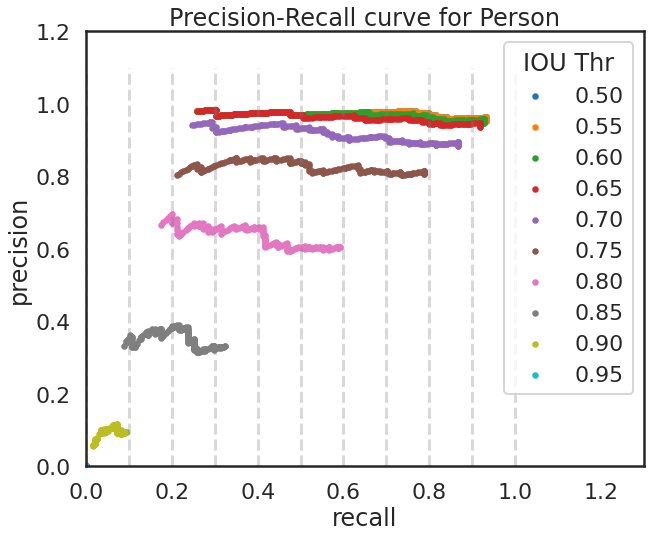

In [ ]:
with open('/content/drive/My Drive/FYP/mask_rcnn/test/ground_truth_boxes.json') as infile:
    gt_boxes = json.load(infile)

with open('/content/drive/My Drive/FYP/mask_rcnn/test/predicted_boxes.json') as infile:
    pred_boxes = json.load(infile)

# Runs it for one IoU threshold
iou_thr = 0.6
start_time = time.time()
data = get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=iou_thr)
end_time = time.time()
print('Single IoU calculation took {:.4f} secs'.format(end_time - start_time))
print('avg precision: {:.4f}'.format(data['avg_prec']))

start_time = time.time()
ax = None
avg_precs = []
iou_thrs = []
for idx, iou_thr in enumerate(np.linspace(0.5, 0.95, 10)):
    data = get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=iou_thr)
    avg_precs.append(data['avg_prec'])
    iou_thrs.append(iou_thr)

    precisions = data['precisions']
    recalls = data['recalls']
    ax = plot_pr_curve(
        precisions, recalls, label='{:.2f}'.format(iou_thr), color=COLORS[idx*2], ax=ax)

# prettify for printing:
avg_precs = [float('{:.4f}'.format(ap)) for ap in avg_precs]
iou_thrs = [float('{:.4f}'.format(thr)) for thr in iou_thrs]
print('map: {:.2f}'.format(100*np.mean(avg_precs)))
print('avg precs: ', avg_precs)
print('iou_thrs:  ', iou_thrs)
plt.legend(loc='upper right', title='IOU Thr', frameon=True)
for xval in np.linspace(0.0, 1.0, 11):
    plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
end_time = time.time()
print('\nPlotting and calculating mAP takes {:.4f} secs'.format(end_time - start_time))
plt.show()